# Model Prediction

## Data preparation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas as pd
raw = pd.read_csv("austin_dockless.csv", low_memory=False)

In [2]:
# plotly
import plotly.plotly as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
import plotly.tools
plotly.tools.set_credentials_file(username='AsherMeyers', api_key='x6WJxUVsTsMwhr5MNLcZ')

In [187]:
test = raw.copy()
test["Start Time"] = pd.to_datetime(test["Start Time"], format = "%m/%d/%Y %I:%M:%S %p")
test["End Time"] = pd.to_datetime(test["End Time"], format = "%m/%d/%Y %I:%M:%S %p")
test["hour"] = test["Start Time"].map(lambda x: x.hour)

In [188]:
test = test[test["Origin Cell ID"] != 'OUT_OF_BOUNDS']
test = test[test["Destination Cell ID"] != 'OUT_OF_BOUNDS']
test = test[np.isfinite(test['Start Latitude'])]
test = test[np.isfinite(test['End Latitude'])]
test = test[np.isfinite(test['Council District (Start)'])]
test = test[pd.notnull(test['Origin Cell ID'])]

test = test[test["Start Latitude"] != 0]
#test = test[:100000]  # same as df.head(10)
# 8 months of data

In [189]:
test['datestart'] = test["Start Time"].apply(lambda x: x.date())

In [74]:
raw.columns

Index(['ID', 'Device ID', 'Vehicle Type', 'Trip Duration', 'Trip Distance',
       'Start Time', 'End Time', 'Modified Date', 'Month', 'Hour',
       'Day of Week', 'Council District (Start)', 'Council District (End)',
       'Origin Cell ID', 'Destination Cell ID', 'Year', 'Start Latitude',
       'Start Longitude', 'End Latitude', 'End Longitude'],
      dtype='object')

In [6]:
def f(x):
    d = {}
    d['CountID'] = x['ID'].count()
    d['TripDurMean'] = x['Trip Duration'].mean()
    d['TripDistMean'] = x['Trip Distance'].mean()
    #d['StartMean'] = x['Start Time'].mean()
    #d['EndMean'] = x['End Team'].mean()
    return pd.Series(d, index=['CountID', 'TripDurMean', 'TripDistMean'])

In [7]:
scooters = test.groupby('datestart').apply(f)

In [8]:
from pandas import DataFrame
from pandas import concat
scooters = DataFrame(scooters)
scooters = scooters.reset_index()


In [37]:
scooters = scooters[scooters.CountID > 100]

In [38]:
scooters.head()

,datestart,CountID,TripDurMean,TripDistMean
2,2018-04-05,112.0,1198.633929,2238.776786
3,2018-04-06,351.0,1118.914530,2616.518519
4,2018-04-07,222.0,970.707207,1815.882883
5,2018-04-08,360.0,1727.847222,3497.075000
6,2018-04-09,225.0,1559.311111,3118.777778


In [40]:
scooters.to_csv('scooters.csv')

## Model Preparation

In [41]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [42]:
sample = scooters[['datestart','CountID']]

In [51]:
sample.head()

,datestart,CountID
2,2018-04-05,112.0
3,2018-04-06,351.0
4,2018-04-07,222.0
5,2018-04-08,360.0
6,2018-04-09,225.0


sample.head()

In [52]:
values = DataFrame(sample.CountID)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

     t-1    t+1
2    NaN  112.0
3  112.0  351.0
4  351.0  222.0
5  222.0  360.0
6  360.0  225.0


In [53]:
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [54]:
# persistence model
def model_persistence(x):
    return x

In [55]:
# walk-forward validation
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 15683278.277


## Walk Forward Graphic

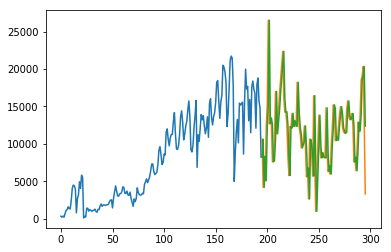

In [56]:
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.show()

LTSM Univariate MODEL

In [57]:
#LTSM Model

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [58]:
numpy.random.seed(7)

dataset = DataFrame(sample.CountID)




In [59]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

198 99


In [60]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [62]:

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(len(trainX), len(testX), len(trainY), len(testY))

196 97 196 97


In [63]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [64]:
print(len(trainX), len(testX))


196 97


In [65]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0831
Epoch 2/100
 - 0s - loss: 0.0360
Epoch 3/100
 - 0s - loss: 0.0270
Epoch 4/100
 - 0s - loss: 0.0216
Epoch 5/100
 - 0s - loss: 0.0165
Epoch 6/100
 - 0s - loss: 0.0125
Epoch 7/100
 - 0s - loss: 0.0099
Epoch 8/100
 - 0s - loss: 0.0086
Epoch 9/100
 - 0s - loss: 0.0079
Epoch 10/100
 - 0s - loss: 0.0075
Epoch 11/100
 - 0s - loss: 0.0074
Epoch 12/100
 - 0s - loss: 0.0074
Epoch 13/100
 - 0s - loss: 0.0073
Epoch 14/100
 - 0s - loss: 0.0073
Epoch 15/100
 - 0s - loss: 0.0073
Epoch 16/100
 - 0s - loss: 0.0074
Epoch 17/100
 - 0s - loss: 0.0074
Epoch 18/100
 - 0s - loss: 0.0074
Epoch 19/100
 - 0s - loss: 0.0073
Epoch 20/100
 - 0s - loss: 0.0073
Epoch 21/100
 - 0s - loss: 0.0074
Epoch 22/100
 - 0s - loss: 0.0073
Epoch 23/100
 - 0s - loss: 0.0074
Epoch 24/100
 - 0s - loss: 0.0073
Epoch 25/100
 - 0s - loss: 0.0072
Epoch 26/100
 - 0s - loss: 0.0072
Epoch 27/100
 - 0s - loss: 0.0072
Epoch 28/100
 - 0s - loss: 0.0072
Epoch 29/100
 - 0s - loss: 0.0072
Epoch 30/100
 - 0s - lo

In [66]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2145.48 RMSE
Test Score: 3582.74 RMSE


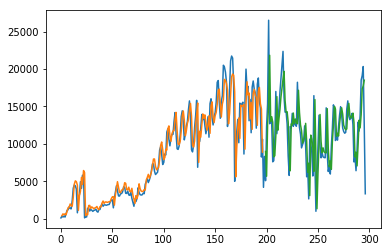

In [67]:

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [68]:
trainPredict[-3:]

array([[15380.596],
       [14676.66 ],
       [ 8898.599]], dtype=float32)

In [69]:
testPredict[-3:]

array([[17350.73],
       [17742.7 ],
       [18499.16]], dtype=float32)

LTSM Multivariate MODEL

In [190]:
test2 = test.copy()

In [191]:
def g(x):
    d = {}
    d['CountID'] = x['ID'].count()
    d['TripDurMean'] = x['Trip Duration'].mean()
    d['TripDistMean'] = x['Trip Distance'].mean()
    d['Day of Week'] = x['Day of Week'].mean()
    #d['StartMean'] = x['Start Time'].mean()
    #d['EndMean'] = x['End Team'].mean()
    return pd.Series(d, index=['CountID', 'TripDurMean', 'TripDistMean','Day of Week'])




In [193]:
mvscooters = test2.groupby('datestart').apply(g)

In [194]:
mvscooters.head()

,CountID,TripDurMean,TripDistMean,Day of Week
datestart,,,,
2018-04-03,1.0,943.000000,419.000000,2.0
2018-04-04,3.0,1360.333333,5691.333333,3.0
2018-04-05,112.0,1198.633929,2238.776786,4.0
2018-04-06,351.0,1118.914530,2616.518519,5.0
2018-04-07,222.0,970.707207,1815.882883,6.0


In [195]:
mvscooters = mvscooters[mvscooters.CountID > 100]

In [196]:
mvscooters.head()

,CountID,TripDurMean,TripDistMean,Day of Week
datestart,,,,
2018-04-05,112.0,1198.633929,2238.776786,4.0
2018-04-06,351.0,1118.914530,2616.518519,5.0
2018-04-07,222.0,970.707207,1815.882883,6.0
2018-04-08,360.0,1727.847222,3497.075000,0.0
2018-04-09,225.0,1559.311111,3118.777778,1.0


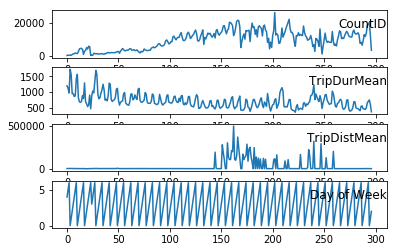

In [197]:
from pandas import read_csv
from matplotlib import pyplot
values = mvscooters.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(mvscooters.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [199]:
from sklearn.preprocessing import LabelEncoder

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = mvscooters.copy()
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.000000   0.612108   0.008915   0.666667  0.009055
2   0.009055   0.553677   0.009673   0.833333  0.004168
3   0.004168   0.445048   0.008065   1.000000  0.009396
4   0.009396   1.000000   0.011441   0.000000  0.004281
5   0.004281   0.876470   0.010682   0.166667  0.021900


In [221]:
# split into train and test sets
numpy.random.seed(8)
values = reframed.values
n_train_hours = int(len(values) * 0.66)
#train = values[0:n_train_hours, :]
#test = values[n_train_hours:len(values), :]
train = values[0:n_train_hours, :]
test = values[n_train_hours:len(values), :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


#X = dataframe.values
#train_size = int(len(X) * 0.66)
#train, test = X[1:train_size], X[train_size:]
#train_X, train_y = train[:,0], train[:,1]
#test_X, test_y = test[:,0], test[:,1]

(195, 1, 4) (195,) (101, 1, 4) (101,)


Train on 195 samples, validate on 101 samples
Epoch 1/50
 - 2s - loss: 0.3088 - val_loss: 0.4232
Epoch 2/50
 - 0s - loss: 0.2924 - val_loss: 0.4046
Epoch 3/50
 - 0s - loss: 0.2760 - val_loss: 0.3863
Epoch 4/50
 - 0s - loss: 0.2621 - val_loss: 0.3687
Epoch 5/50
 - 0s - loss: 0.2503 - val_loss: 0.3519
Epoch 6/50
 - 0s - loss: 0.2404 - val_loss: 0.3363
Epoch 7/50
 - 0s - loss: 0.2319 - val_loss: 0.3214
Epoch 8/50
 - 0s - loss: 0.2242 - val_loss: 0.3072
Epoch 9/50
 - 0s - loss: 0.2172 - val_loss: 0.2937
Epoch 10/50
 - 0s - loss: 0.2111 - val_loss: 0.2808
Epoch 11/50
 - 0s - loss: 0.2058 - val_loss: 0.2690
Epoch 12/50
 - 0s - loss: 0.2015 - val_loss: 0.2581
Epoch 13/50
 - 0s - loss: 0.1977 - val_loss: 0.2480
Epoch 14/50
 - 0s - loss: 0.1945 - val_loss: 0.2386
Epoch 15/50
 - 0s - loss: 0.1917 - val_loss: 0.2301
Epoch 16/50
 - 0s - loss: 0.1888 - val_loss: 0.2222
Epoch 17/50
 - 0s - loss: 0.1862 - val_loss: 0.2148
Epoch 18/50
 - 0s - loss: 0.1836 - val_loss: 0.2077
Epoch 19/50
 - 0s - loss: 0

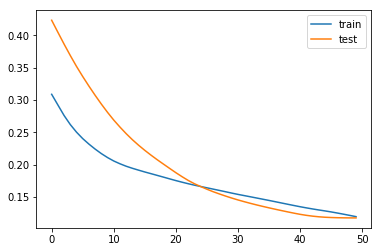

In [224]:
# design network
model2 = Sequential()
model2.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

##Evaluate

In [225]:

from keras.layers import Concatenate
# make a prediction
yhat = model2.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [242]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [248]:
import math
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3919.988


In [252]:
yhat[-3:]

array([[0.5585367 ],
       [0.4273869 ],
       [0.34198684]], dtype=float32)

In [251]:
test_X[-3:]

array([[0.7200773 , 0.25287703, 0.00854635, 1.        ],
       [0.76584697, 0.28505477, 0.00755182, 0.        ],
       [0.46459287, 0.17767489, 0.00722205, 0.16666667]], dtype=float32)